In [1]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests
import tqdm
from time import sleep
import time
from PIL import Image
from io import BytesIO
from adjustText import adjust_text
from scipy.interpolate import interp1d
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name, get_teams, find_team_name_by_id
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail


In [2]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Rectangle
from matplotlib.ticker import FormatStrFormatter


import matplotlib.ticker as mtick

In [3]:
from nba_api.stats.endpoints.synergyplaytypes import SynergyPlayTypes
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats


In [4]:
plt.style.use('fivethirtyeight')

In [5]:
play_types = [
    "PRBallHandler",
    "Isolation",
    "Transition",
    "Spotup",
    "Handoff",
    "OffScreen",
    "Cut",
    "OffRebound",
    "Postup",
    "PRRollman",
]

play_types_seasons = {}
play_types_seasons_players = {}

    
def download_play_type_data(season='2023-24'):
    
    play_type_dict = {}
    if season not in play_types_seasons:
        print("Retrieving play types...")
        for play in play_types:
            synergy = SynergyPlayTypes(player_or_team_abbreviation='T', play_type_nullable=play, type_grouping_nullable="offensive", per_mode_simple="PerGame", season=season)
            synergy_df = synergy.get_data_frames()[0]
            play_type_dict[play] = synergy_df
            time.sleep(1)
        play_types_seasons[season] = play_type_dict
    else:
        play_type_dict = play_types_seasons[season]

    
    return play_type_dict


def download_play_type_data_player(season='2023-24'):
    
    play_type_dict = {}
    if season not in play_types_seasons_players:
        print("Retrieving play types...")
        for play in play_types:
            print(f"Loading play: {play}")
            synergy = SynergyPlayTypes(player_or_team_abbreviation='P', play_type_nullable=play, type_grouping_nullable="offensive", per_mode_simple="PerGame", season=season)
            synergy_df = synergy.get_data_frames()[0]
            play_type_dict[play] = synergy_df
            time.sleep(1)
        play_types_seasons_players[season] = play_type_dict
    else:
        play_type_dict = play_types_seasons_players[season]

    
    return play_type_dict



In [35]:
def plot_bar_chart(dict_data_values, title, colors):    
    fig, ax = plt.subplots(figsize=(24, 16))

    num_labels = len(dict_data_values.keys())
    bar_width = 1 / (num_labels+1)
    for index, key in enumerate(dict_data_values):
        
        values = dict_data_values[key].tolist()[0:-1]
        labels = dict_data_values[key].keys()[0:-1]
        ticks = [i+index * bar_width for i in range(len(labels))]
        ax.bar(x=ticks, height=values, width=bar_width, label=key, color=colors[index], alpha=0.9, linewidth=0.5, edgecolor='black')
        
    ax.set_xticklabels([''] + list(labels), size=18)
    #ax.set_yticklabels(labels=range(-1, 7), size=18)
    if num_labels % 2 == 0:
        modifier = bar_width * num_labels/2 - bar_width/2
    else:
        modifier = bar_width * (num_labels-2)
    ax.set_xticks([i+modifier for i in range(-1, len(labels))])
    ax.legend(fontsize=18)
    #ax.set_xlabel("Play Type", size=32)
    #ax.set_ylabel("% of All Possessions", size=32)
    ax.set_xlabel("Vrsta akcije", size=32)
    ax.set_ylabel("% svih posjeda", size=32)
    ax.set_title(title, size=40)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.text(x=0.25, y=-2, s='source: stats.nba.com', fontsize=14, ha='left')
    ax.text(x=8.25, y=-2, s='twitter: @daniel_bratulic', fontsize=14, ha='right')
    ax.grid(False, axis='x')

In [7]:
last_year = download_play_type_data(season='2022-23')

Retrieving play types...


In [8]:
cur_year = download_play_type_data(season='2023-24')

Retrieving play types...


In [9]:
def get_interesting_data(df, target_column):
    final_df = None
    for index, play in enumerate(play_types):
        columns = ["TEAM_NAME", target_column]
        result = df[play].loc[:, columns]
        result = result.rename(columns={target_column: f'{target_column}_{play}'})
        if index == 0:
            final_df = result
        else:
            final_df = pd.merge(left=final_df, right=result, on='TEAM_NAME')
    return final_df


def get_merged_data(first_year, second_year, target_column):
    
    target_columns = [
        f"{target_column}_PRBallHandler",
        f"{target_column}_Isolation",
        f"{target_column}_Transition",
        f"{target_column}_Spotup",
        f"{target_column}_Handoff",
        f"{target_column}_OffScreen",
        f"{target_column}_Cut",
        f"{target_column}_OffRebound",
        f"{target_column}_Postup",
        f"{target_column}_PRRollman",
    ]

    
    
    first_df = get_interesting_data(first_year, target_column)
    second_df = get_interesting_data(second_year, target_column)
    merged_df = pd.merge(left=first_df, right=second_df, on='TEAM_NAME', suffixes=('_last', '_cur'))
    for play in play_types:
        merged_df.loc[:, f'{play}_diff'] = (merged_df[f'{target_column}_{play}_cur'] - merged_df[f'{target_column}_{play}_last'])**2
        
    merged_df.loc[:, "LAST_NORM"] = ((merged_df.loc[:, [f"{item}_last" for item in target_columns]]) ** 2).sum(axis=1) ** (1/2)
    merged_df.loc[:, "CUR_NORM"] = ((merged_df.loc[:, [f"{item}_cur" for item in target_columns]]) ** 2).sum(axis=1) ** (1/2)
    
    dot_product = []
    for i in range(len(merged_df)):
        last_numpy = merged_df.loc[:, [f"{item}_last" for item in target_columns]].to_numpy()[i]
        cur_numpy = merged_df.loc[:, [f"{item}_cur" for item in target_columns]].to_numpy()[i]
        dot_product.append(last_numpy.dot(cur_numpy))
    merged_df.loc[:, "DOT_PRODUCT"] = dot_product
    return merged_df
    

In [10]:
last_df = get_interesting_data(last_year, 'POSS')
cur_df = get_interesting_data(cur_year, 'POSS')

In [11]:
target_stat = 'POSS'
merged_df = get_merged_data(last_year, cur_year, target_stat)

In [12]:
diff_columns = [item for item in merged_df.columns.tolist() if '_diff' in item]

In [13]:
merged_df.loc[:, "EUCLIDEAN_DISTANCE"] = merged_df.loc[:, diff_columns].abs().sum(axis=1) ** (1/2)

In [14]:
merged_df.loc[:, "COSINE_SIMILARITY"] = merged_df.DOT_PRODUCT / (merged_df.LAST_NORM * merged_df.CUR_NORM)

In [15]:
merged_df.sort_values(by='COSINE_SIMILARITY')

TEAM_NAME  POSS_PRBallHandler_last  POSS_Isolation_last  \
27      Philadelphia 76ers                     15.6                 12.6   
16          Boston Celtics                     17.6                  8.8   
9        Memphis Grizzlies                     20.9                  5.2   
24         Toronto Raptors                     17.7                  8.7   
12            Phoenix Suns                     19.9                  5.1   
26   Golden State Warriors                     15.5                  4.6   
3   Portland Trail Blazers                     19.4                  9.0   
5          Houston Rockets                     22.4                  7.7   
25           Brooklyn Nets                     16.1                 10.0   
11             LA Clippers                     19.2                  9.5   
20      Washington Wizards                     18.3                  7.1   
19       San Antonio Spurs                     19.4                  3.8   
21  Minnesota Timberwolves                     17.2                  7.9   
18        Dallas Mavericks                     16.3                 13.0   
1            Chicago Bulls                     22.7                  7.0   
14              Miami Heat                     18.3                  7.3   
17               Utah Jazz                     18.8                  6.3   
8          New York Knicks                     19.8                 10.3   
22         Milwaukee Bucks                     16.7                  7.2   
2      Cleveland Cavaliers                     21.1                  7.0   
0            Atlanta Hawks                     24.5                  8.4   
13       Charlotte Hornets                     21.5                  4.6   
6          Detroit Pistons                     22.8                  7.4   
15      Los Angeles Lakers                     19.2                  9.8   
7            Orlando Magic                     20.7                  6.9   
23    New Orleans Pelicans                     17.2                  6.1   
28        Sacramento Kings                     14.7                  5.4   
29          Denver Nuggets                     14.6                  6.0   
4    Oklahoma City Thunder                     21.1                  9.1   
10          Indiana Pacers                     20.1                  5.0   

    POSS_Transition_last  POSS_Spotup_last  POSS_Handoff_last  \
27                  16.4              26.0                2.9   
16                  19.0              30.1                3.7   
9                   22.7              25.7                6.0   
24                  21.0              24.5                3.8   
12                  15.1              28.6                5.0   
26                  19.0              24.0                8.0   
3                   16.5              24.9                6.2   
5                   16.9              25.4                6.3   
25                  19.0              26.2                6.0   
11                  18.4              26.2                3.5   
20                  16.7              26.2                5.2   
19                  18.9              28.0                8.6   
21                  20.1              28.2                4.9   
18                  15.9              28.5                3.5   
1                   17.5              27.1                2.0   
14                  15.7              24.1                7.0   
17                  18.9              25.4                6.5   
8                   18.5              28.7                6.0   
22                  20.0              26.7                5.7   
2                   16.6              22.9                4.4   
0                   18.7              24.1                3.5   
13                  20.1              26.8                5.5   
6                   17.7              26.4                3.3   
15                  21.0              23.8                3.3   
7                   19.2           

In [16]:

import matplotlib.pyplot as plt
import pandas as pd
from math import pi

def plot_radar(
    title,
    data,
    labels,
    colors,
    alphas,
    ax=None
):
    # number of variable
    categories=list(data[0].tolist())
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    if ax is None:
        fig = plt.figure(figsize=(12, 12))
        ax = plt.subplot(111, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([item.replace("_", " ") for item in data[0].index.tolist()])
    for label,i in zip(ax.get_xticklabels(),range(0,len(angles))):

        angle_rad=angles[i]
        if angle_rad <= pi/2:
            ha= 'left'
            va= "bottom"
            angle_text=angle_rad*(-180/pi)+90
        elif pi/2 < angle_rad <= pi:
            ha= 'left'
            va= "top"
            angle_text=angle_rad*(-180/pi)+90
        elif pi < angle_rad <= (3*pi/2):
            ha= 'right'
            va= "top"  
            angle_text=angle_rad*(-180/pi)-90
        else:
            ha= 'right'
            va= "bottom"
            angle_text=angle_rad*(-180/pi)-90
        label.set_rotation(angle_text)
        label.set_verticalalignment(va)
        label.set_horizontalalignment(ha)


    # Draw ylabels
    ax.set_rlabel_position(0)
    #items = [item for item in range(0, 40, 5)]
    #plt.yticks(items, map(str, items), size=12)
    #ax.spines['polar'].set_color('#cbcbcb')
    #ax.spines['polar'].set_linewidth('1')
    
    max_val = max([item.max() for item in data])
    ax.set_ylim(0, max_val)
    ax.spines['polar'].set_visible(False)

    ax.set_title(title, color='black', size=20, pad=20)
    
    for i in range(len(data)):
    
        cur_data = data[i]
        values=cur_data.tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=labels[i], color=colors[i])
        ax.fill(angles, values, colors[i], alpha=alphas[i])
    
    legend = ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=12)
    
    #ax.set_yticks([item for item in range(0, 35, 5)])
    #ax.set_yticklabels([f"{item}" for item in range(0, 35, 5)], size=12)


    ax.set_frame_on(False)
    ax.set_axisbelow(True)
    #ax.set_facecolor(bball_gray)
    #fig.set_facecolor(bball_gray)

In [17]:
plt.style.use('fivethirtyeight')

C:\Users\danie\AppData\Local\Temp\ipykernel_14808\1637424470.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(labels), size=18)


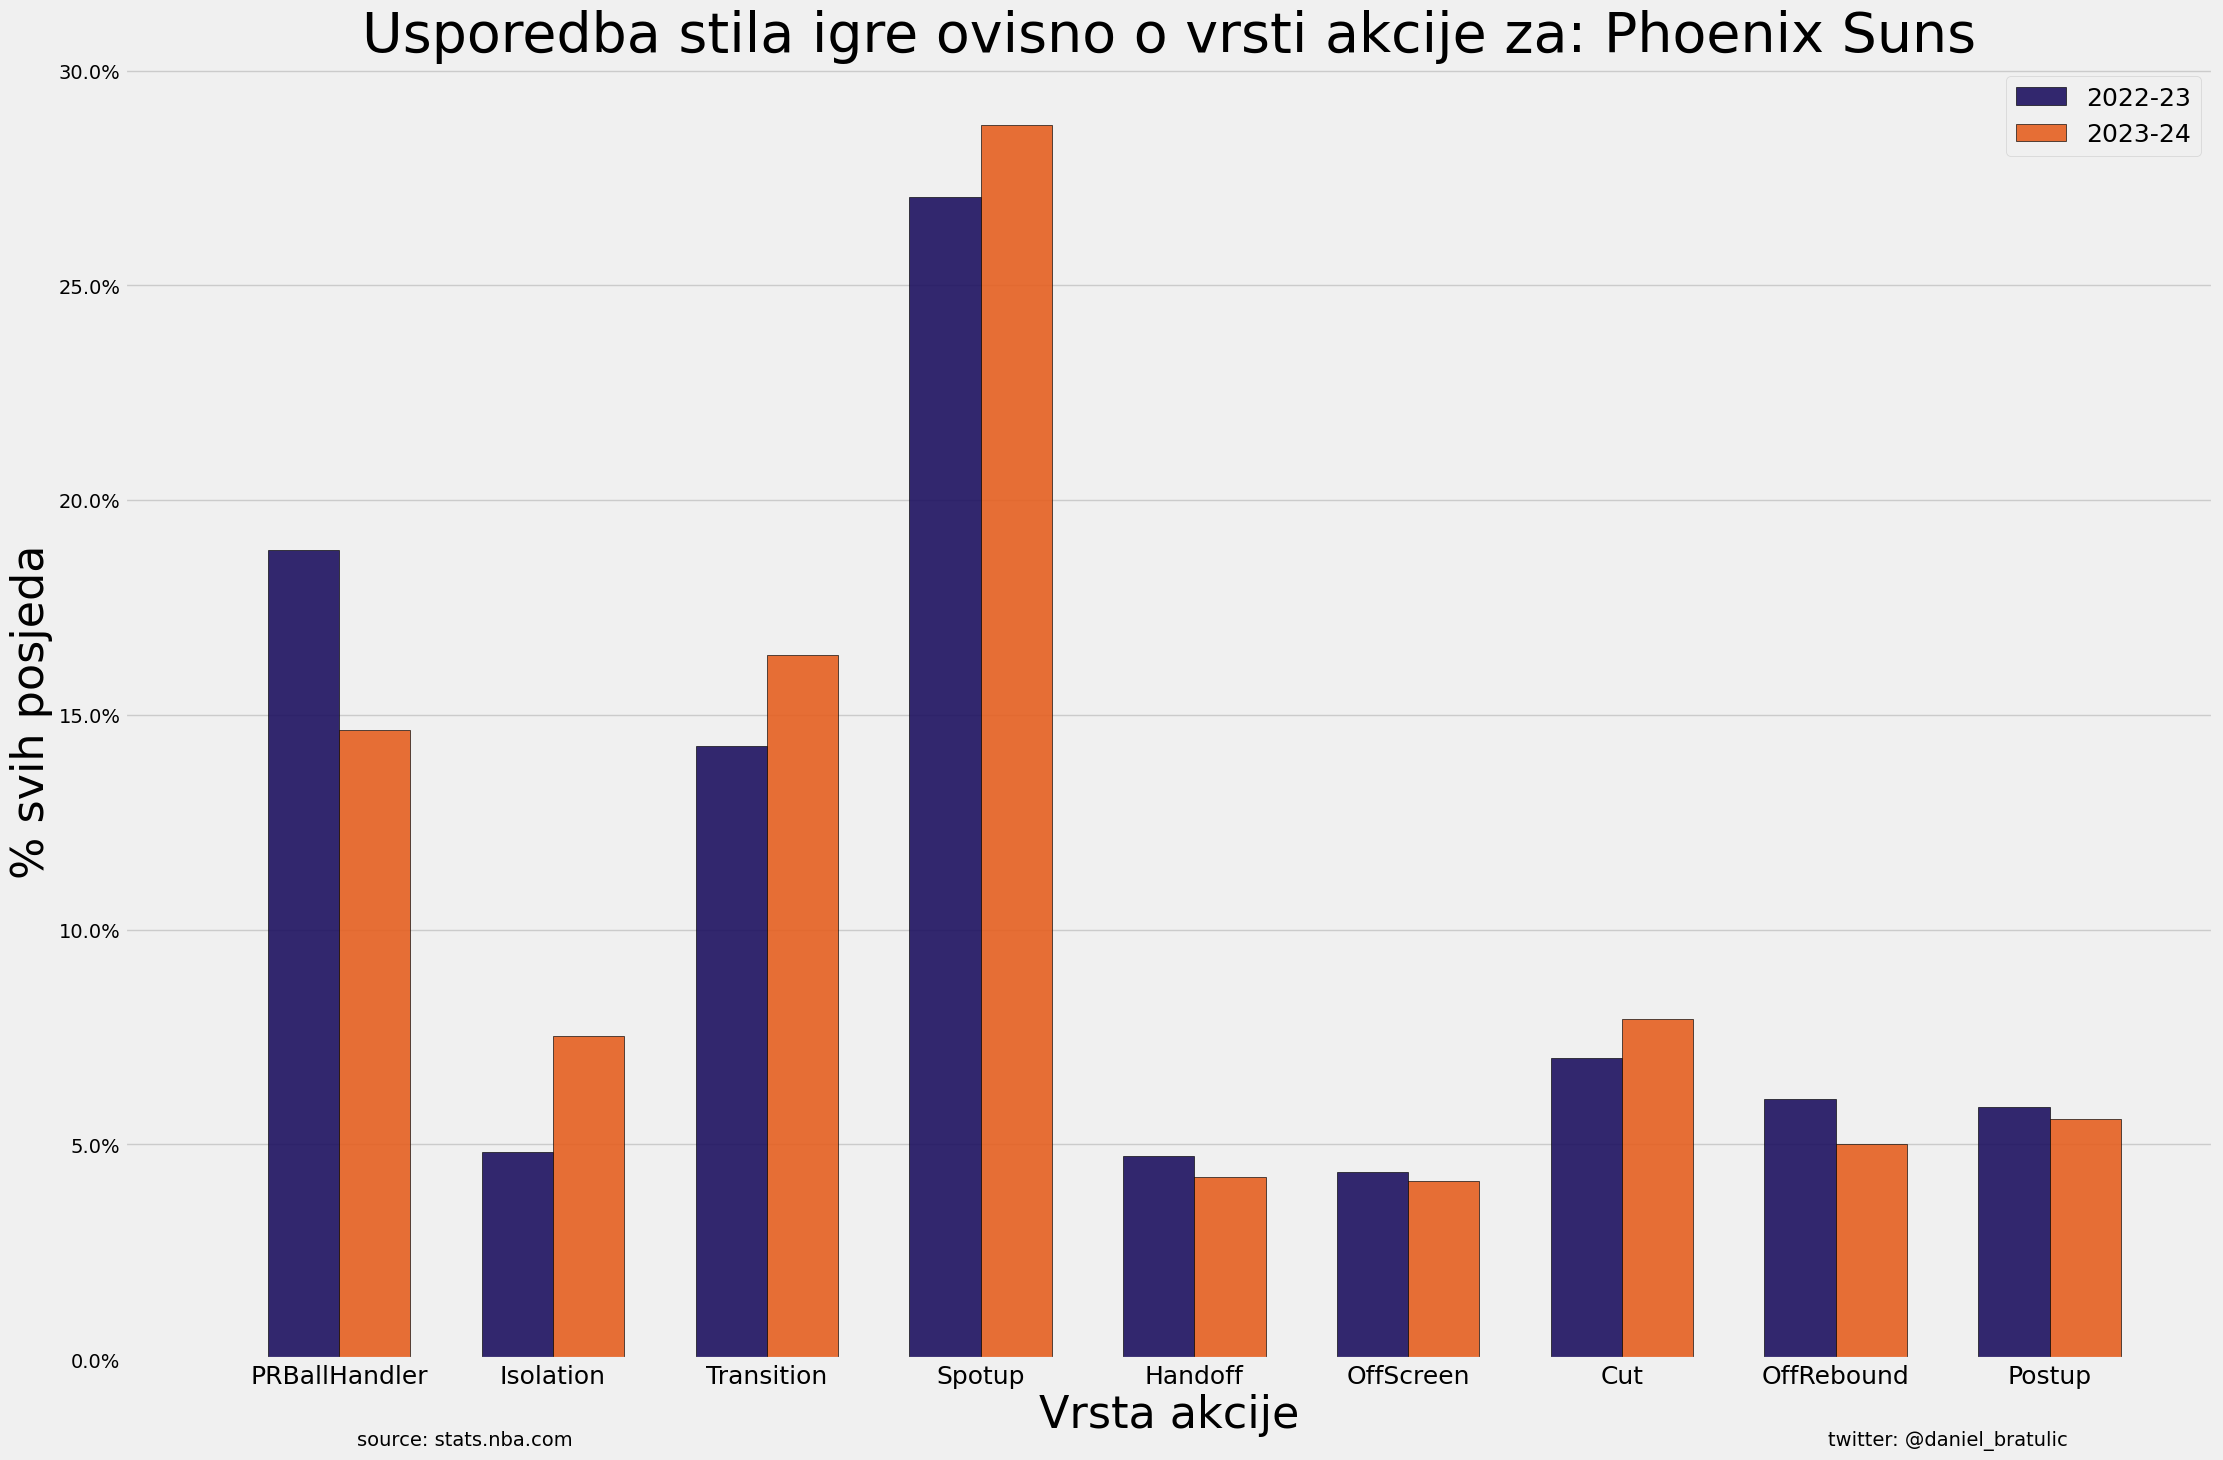

In [36]:
data = {
    '2022-23': team_last.iloc[0],
    '2023-24': team_cur.iloc[0],
}

plot_bar_chart(
    data, 
    f"Usporedba stila igre ovisno o vrsti akcije za: {team_name}",
    #f"Comparison of play tyle based on play type for {team_name}",
    colors=[
        "#1D1160",
        "#E56020"
    ],
)

In [75]:
team_cur.sum(axis=1)

27    107.3
dtype: float64

In [79]:
team_cur.Isolation / team_cur.sum(axis=1)

27    0.087605
dtype: float64

In [78]:
for key in team_cur.columns:
    team_cur.loc[:, key] = team_cur[key] / team_cur.sum(axis=1)

PRBallHandler  Isolation  Transition  Spotup  Handoff  OffScreen  Cut  \
27           16.6        9.4        18.5    21.7      7.1        2.6  7.7   

    OffRebound  Postup  PRRollman  
27         7.8     8.0        7.9

In [27]:
team_cur

PRBallHandler  Isolation  Transition     Spotup   Handoff  OffScreen  \
12      14.657666   7.521697   16.393443  28.736741  4.243009   4.146577   

         Cut  OffRebound    Postup  PRRollman  
12  7.907425    5.014465  5.593057   5.785921

In [26]:
team_last

PRBallHandler  Isolation  Transition     Spotup   Handoff  OffScreen  \
12      18.826868   4.824976   14.285714  27.057711  4.730369   4.351939   

         Cut  OffRebound    Postup  PRRollman  
12  7.000946    6.054872  5.865658   7.000946

In [38]:
merged_df.loc[:, 'ISO_DIFF'] = merged_df.POSS_Isolation_cur - merged_df.POSS_Isolation_last

In [40]:
merged_df.loc[:, 'PR_BH_DIFF'] = merged_df.POSS_PRBallHandler_cur - merged_df.POSS_PRBallHandler_last

In [41]:
merged_df.sort_values(by='PR_BH_DIFF', ascending=True)

TEAM_NAME  POSS_PRBallHandler_last  POSS_Isolation_last  \
12            Phoenix Suns                     19.9                  5.1   
9        Memphis Grizzlies                     20.9                  5.2   
19       San Antonio Spurs                     19.4                  3.8   
11             LA Clippers                     19.2                  9.5   
17               Utah Jazz                     18.8                  6.3   
24         Toronto Raptors                     17.7                  8.7   
5          Houston Rockets                     22.4                  7.7   
14              Miami Heat                     18.3                  7.3   
21  Minnesota Timberwolves                     17.2                  7.9   
0            Atlanta Hawks                     24.5                  8.4   
1            Chicago Bulls                     22.7                  7.0   
4    Oklahoma City Thunder                     21.1                  9.1   
29          Denver Nuggets                     14.6                  6.0   
7            Orlando Magic                     20.7                  6.9   
28        Sacramento Kings                     14.7                  5.4   
23    New Orleans Pelicans                     17.2                  6.1   
6          Detroit Pistons                     22.8                  7.4   
15      Los Angeles Lakers                     19.2                  9.8   
2      Cleveland Cavaliers                     21.1                  7.0   
26   Golden State Warriors                     15.5                  4.6   
16          Boston Celtics                     17.6                  8.8   
10          Indiana Pacers                     20.1                  5.0   
20      Washington Wizards                     18.3                  7.1   
27      Philadelphia 76ers                     15.6                 12.6   
8          New York Knicks                     19.8                 10.3   
13       Charlotte Hornets                     21.5                  4.6   
18        Dallas Mavericks                     16.3                 13.0   
3   Portland Trail Blazers                     19.4                  9.0   
22         Milwaukee Bucks                     16.7                  7.2   
25           Brooklyn Nets                     16.1                 10.0   

    POSS_Transition_last  POSS_Spotup_last  POSS_Handoff_last  \
12                  15.1              28.6                5.0   
9                   22.7              25.7                6.0   
19                  18.9              28.0                8.6   
11                  18.4              26.2                3.5   
17                  18.9              25.4                6.5   
24                  21.0              24.5                3.8   
5                   16.9              25.4                6.3   
14                  15.7              24.1                7.0   
21                  20.1              28.2                4.9   
0                   18.7              24.1                3.5   
1                   17.5              27.1                2.0   
4                   21.8              29.5                3.7   
29                  19.4              22.2                5.9   
7                   19.2              25.3                6.4   
28                  22.7              26.2               10.2   
23                  18.8              26.0                6.1   
6                   17.7              26.4                3.3   
15                  21.0              23.8                3.3   
2                   16.6              22.9                4.4   
26                  19.0              24.0                8.0   
16                  19.0              30.1                3.7   
10                  22.9              27.0                5.8   
20                  16.7              26.2                5.2   
27                  16.4              26.0                2.9   
8                   18.5           

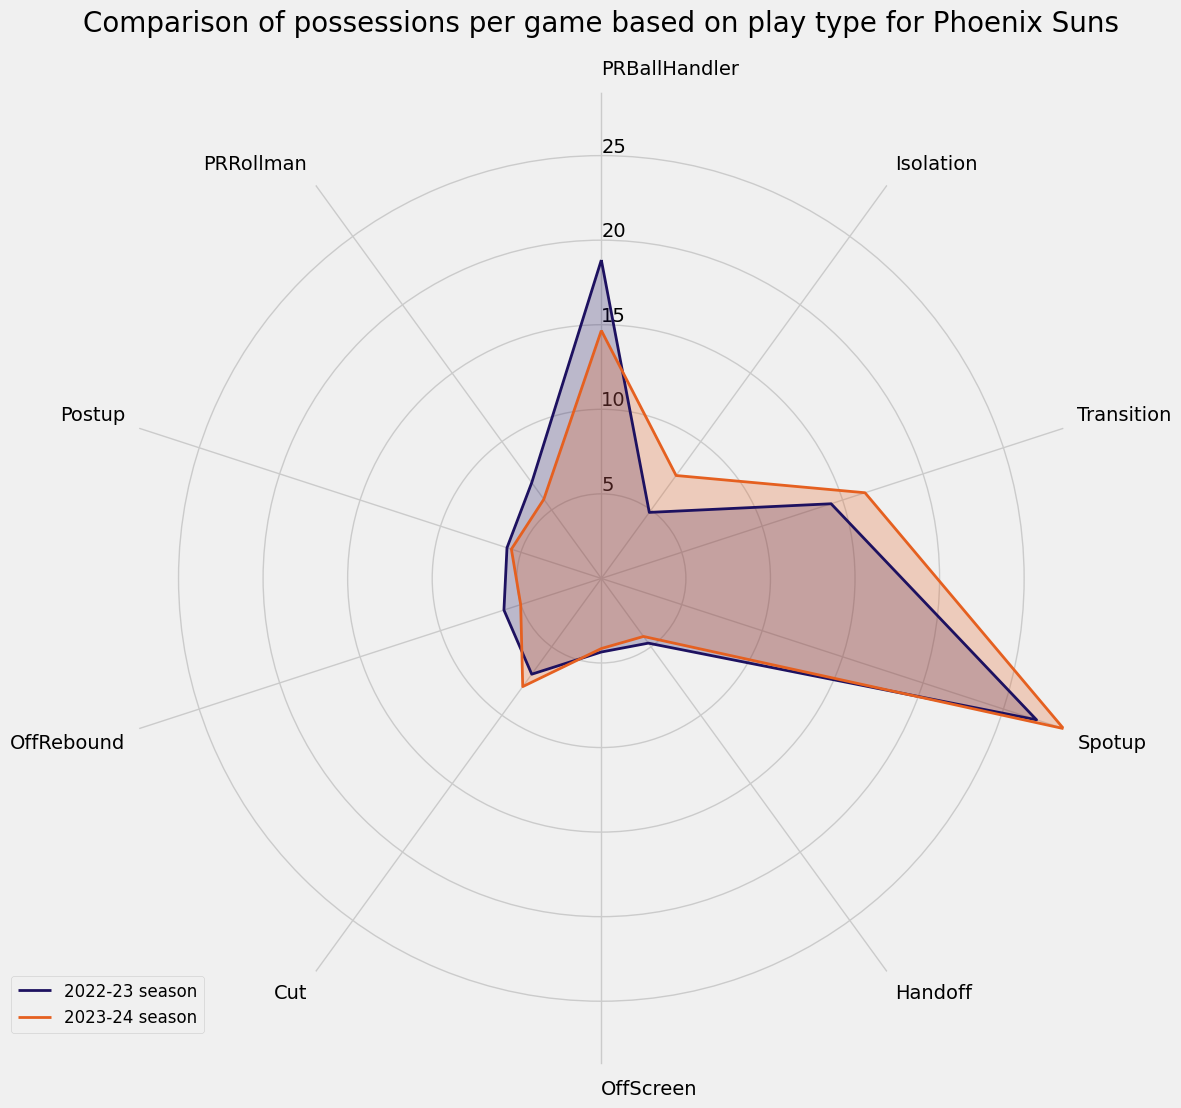

In [25]:
team_name = 'Phoenix Suns'
team_last = merged_df.loc[merged_df.TEAM_NAME == team_name, [column for column in merged_df.columns.tolist() if 'last' in column]]
team_cur = merged_df.loc[merged_df.TEAM_NAME == team_name, [column for column in merged_df.columns.tolist() if 'cur' in column]]

team_last = team_last.rename(columns={item: item.split("_last")[0].split(f"{target_stat}_")[1] for item in team_last.columns})
team_cur = team_cur.rename(columns={item: item.split("_cur")[0].split(f"{target_stat}_")[1] for item in team_cur.columns})

sum_last = team_last.sum(axis=1)
sum_cur = team_cur.sum(axis=1)
for key in team_cur.columns:
    team_last.loc[:, key] = team_last[key] / sum_last * 100
    team_cur.loc[:, key] = team_cur[key] / sum_cur * 100


plot_radar(
    title=f"Comparison of possessions per game based on play type for {team_name}",
    data=[team_last.iloc[0], team_cur.iloc[0]],
    labels=["2022-23 season", "2023-24 season"],
    colors=[
        "#1D1160",
        "#E56020"
    ],
    alphas=[0.25, 0.25]
)

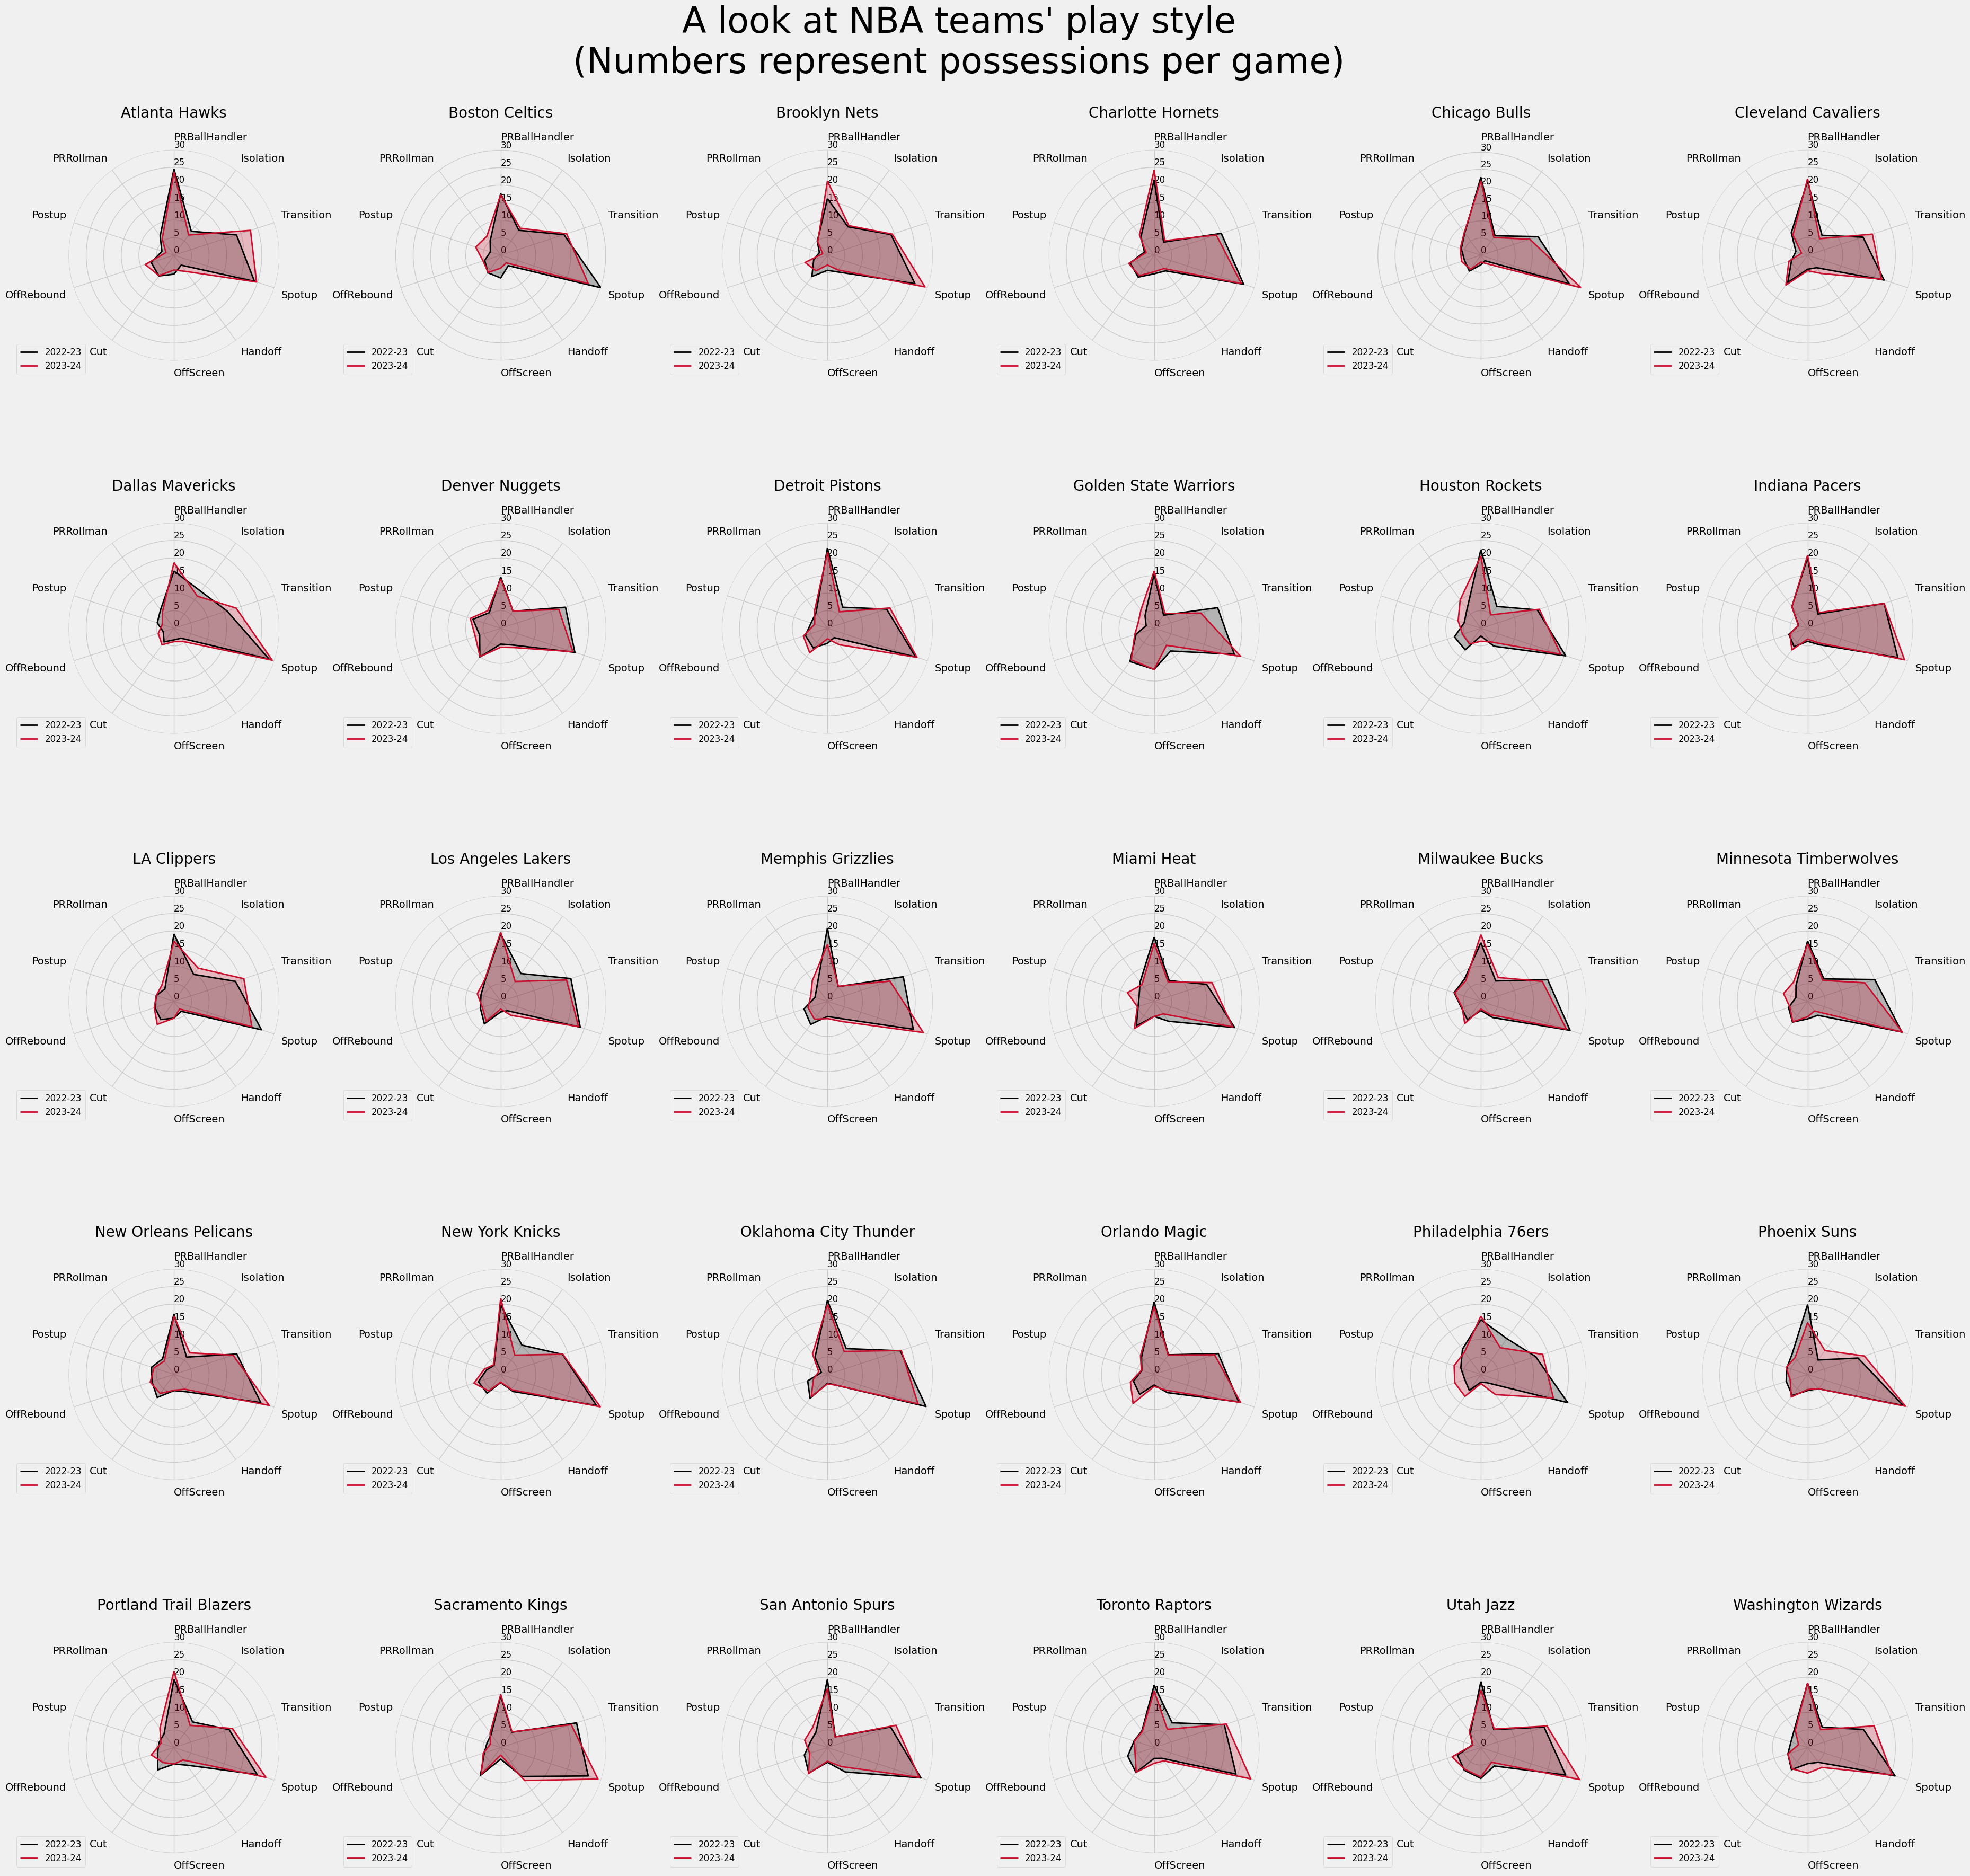

In [73]:
fig, axes = plt.subplots(5, 6, figsize=(40, 40), subplot_kw=dict(polar=True))

axes = axes.flatten()
merged_df = merged_df.sort_values(by='TEAM_NAME')
for index in range(len(merged_df)):

    item = merged_df.iloc[index]
    hou_last = merged_df.loc[merged_df.TEAM_NAME == item.TEAM_NAME, [column for column in merged_df.columns.tolist() if 'last' in column]]
    hou_cur = merged_df.loc[merged_df.TEAM_NAME == item.TEAM_NAME, [column for column in merged_df.columns.tolist() if 'cur' in column]]

    hou_last = hou_last.rename(columns={item: item.split("_last")[0].split("POSS_")[1] for item in hou_last.columns})
    hou_cur = hou_cur.rename(columns={item: item.split("_cur")[0].split("POSS_")[1] for item in hou_cur.columns})
    cur_ax = axes[index]
    plot_radar(
        title=f"{item.TEAM_NAME}",
        data=[hou_last.iloc[0], hou_cur.iloc[0]],
        labels=["2022-23", "2023-24"],
        colors=[
            "#000000",
            "#C8102E"
        ],
        alphas=[0.25, 0.25],
        ax=cur_ax
    )
    axes[index] = cur_ax

plt.suptitle("A look at NBA teams' play style\n(Numbers represent possessions per game)", size=48)
plt.subplots_adjust(wspace=0.55, hspace=0.00001, top=0.95)
plt.savefig('radar_diff.png', dpi=120, bbox_inches='tight')

In [54]:
teams = [
    'Phoenix Suns',
    'Memphis Grizzlies',
    'Golden State Warriors',
    'Utah Jazz',
    'Miami Heat',
    'Milwaukee Bucks',
    'Philadelphia 76ers',
    'Boston Celtics'
]

team_colors = {
    'Boston Celtics': '#007A33',
    'Phoenix Suns': '#E56020',
    'Memphis Grizzlies': '#5D76A9',
    'Golden State Warriors': '#1D428A',
    'Utah Jazz': '#002B5C',
    'Miami Heat': '#98002E',
    'Milwaukee Bucks': '#00471B',
    'Philadelphia 76ers': '#006BB6',
}

In [55]:
subset_df = merged_df.loc[merged_df.TEAM_NAME.isin(teams)]

In [56]:
subset_df.loc[:, 'COLOR'] = [team_colors[name] for name in subset_df.TEAM_NAME.unique()]

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


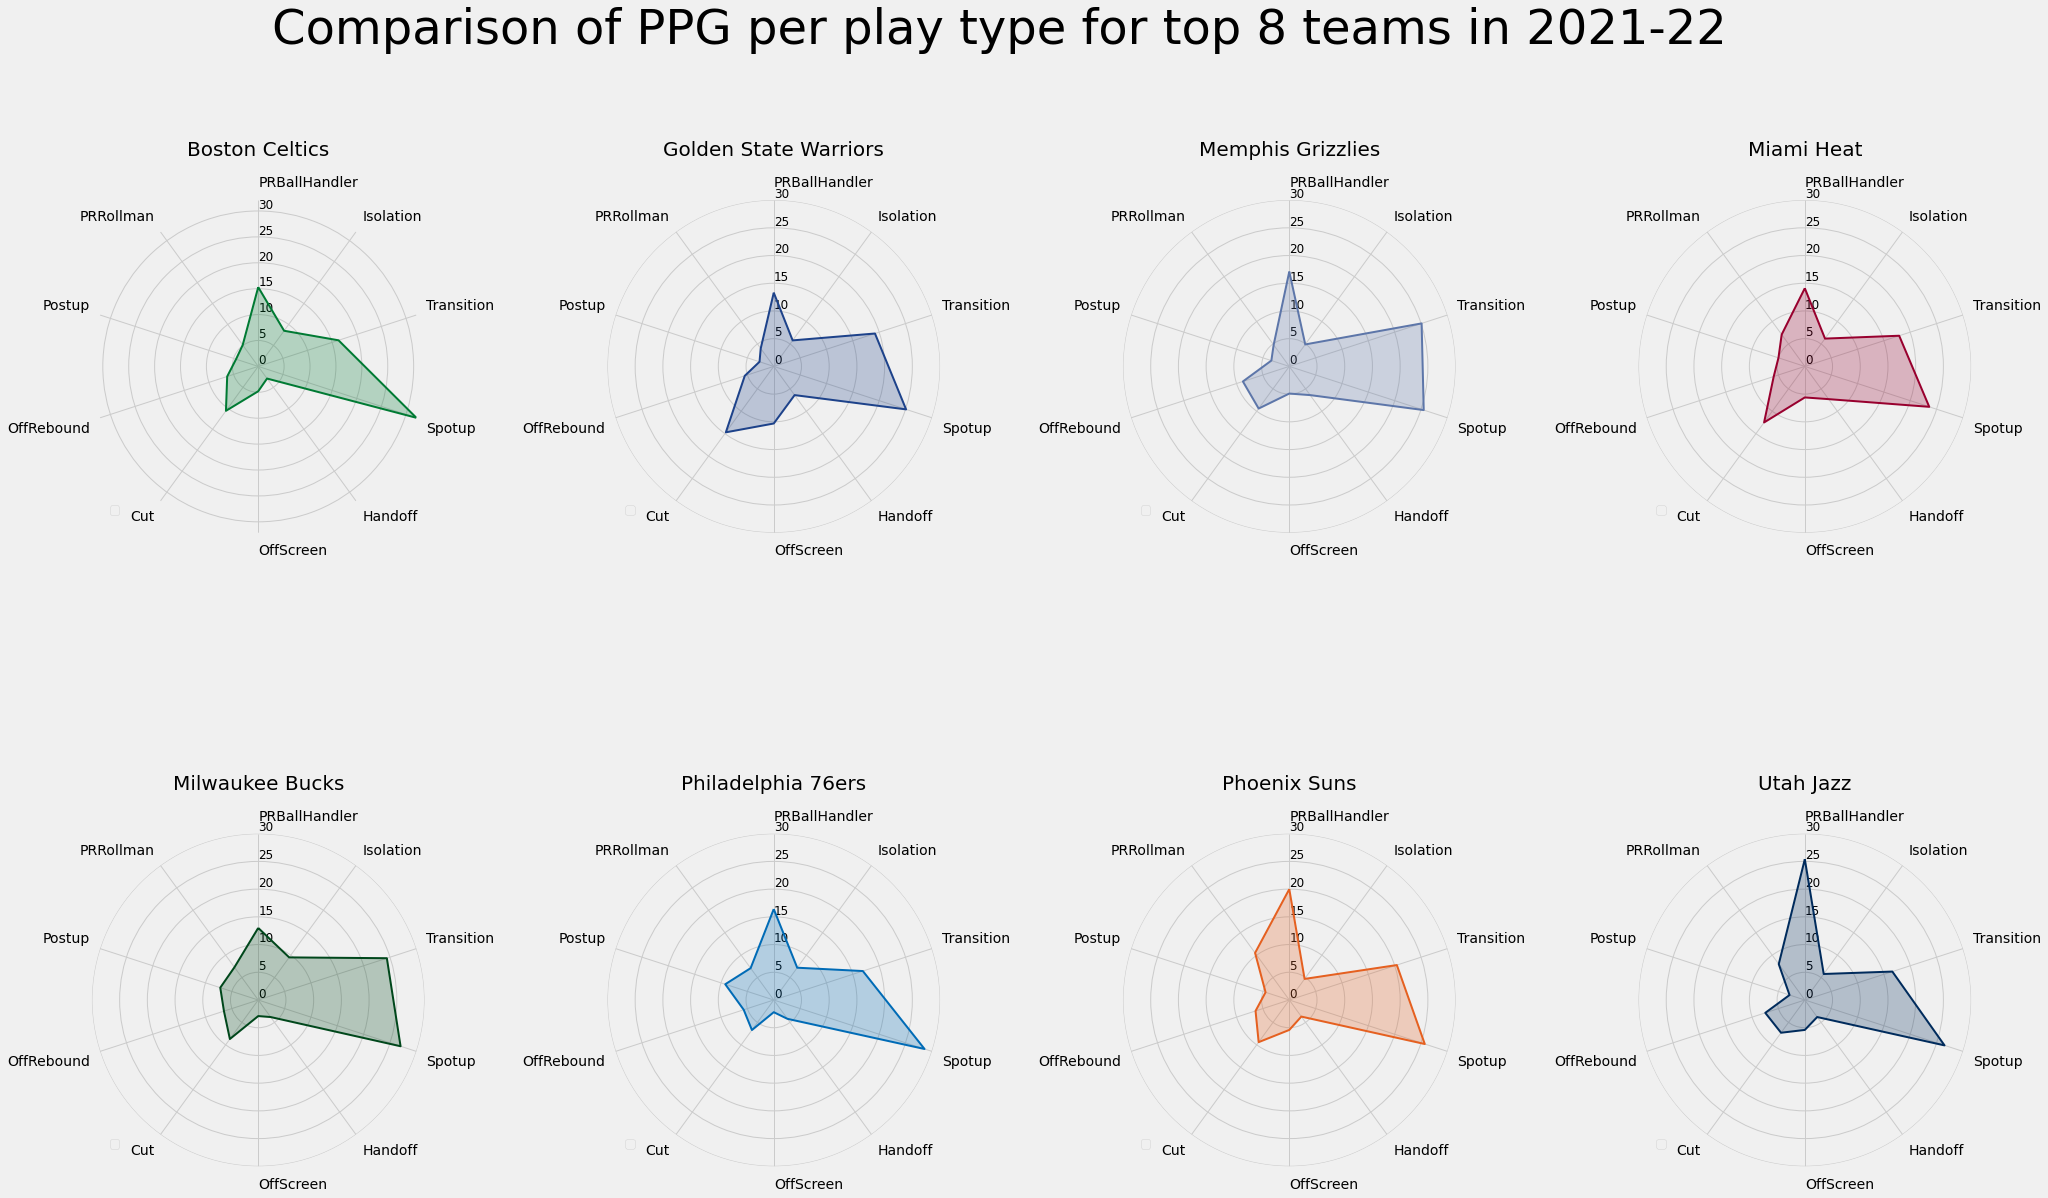

In [73]:
fig, axes = plt.subplots(2, 4, figsize=(30, 20), subplot_kw=dict(polar=True))

axes = axes.flatten()
subset_df = subset_df.sort_values(by='TEAM_NAME')
for index in range(len(subset_df)):
    item = subset_df.iloc[index]
    team_cur = subset_df.loc[subset_df.TEAM_NAME == item.TEAM_NAME, [column for column in subset_df.columns.tolist() if 'cur' in column]]

    team_cur = team_cur.rename(columns={item: item.split("_cur")[0].split("PTS_")[1] for item in team_cur.columns})
    cur_ax = axes[index]
    plot_radar(
        title=f"{item.TEAM_NAME}",
        data=[team_cur.iloc[0]],
        labels=[""],
        colors=[
            item.COLOR,
        ],
        alphas=[0.25],
        ax=cur_ax
    )
    axes[index] = cur_ax
    
plt.suptitle("Comparison of PPG per play type for top 8 teams in 2021-22", size=48)
plt.subplots_adjust(wspace=0.55, hspace=0, top=0.95)
plt.savefig('radar_diff.png', dpi=120, bbox_inches='tight')

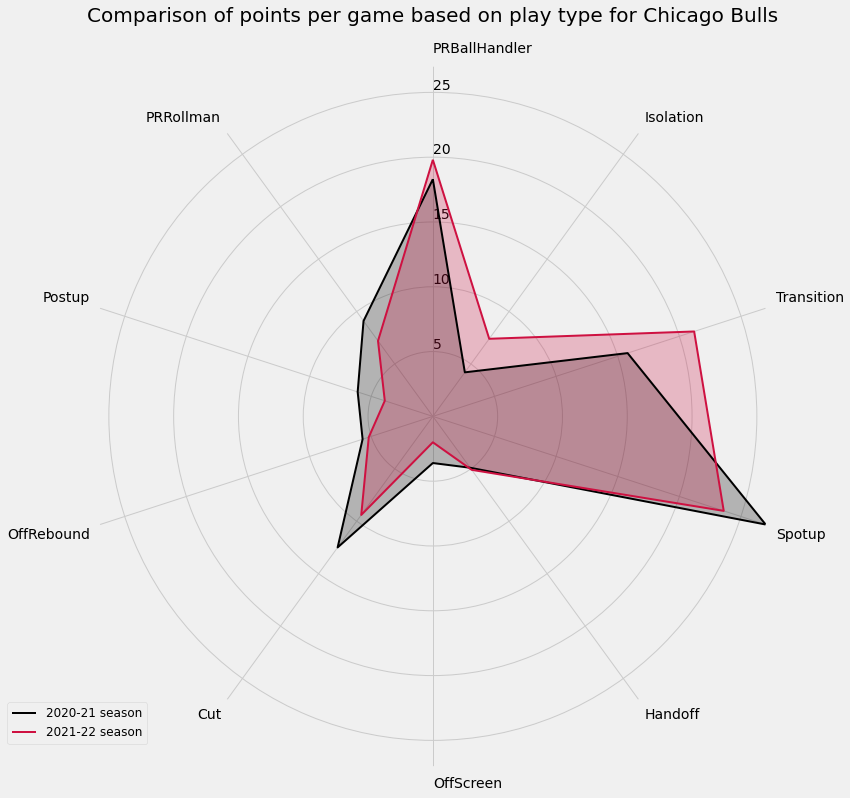

In [17]:
team_name = 'Chicago Bulls'
team_last = merged_df.loc[merged_df.TEAM_NAME == team_name, [column for column in merged_df.columns.tolist() if 'last' in column]]
team_cur = merged_df.loc[merged_df.TEAM_NAME == team_name, [column for column in merged_df.columns.tolist() if 'cur' in column]]

team_last = team_last.rename(columns={item: item.split("_last")[0].split(f"{target_stat}_")[1] for item in team_last.columns})
team_cur = team_cur.rename(columns={item: item.split("_cur")[0].split(f"{target_stat}_")[1] for item in team_cur.columns})

plot_radar(
    title=f"Comparison of points per game based on play type for {team_name}",
    data=[team_last.iloc[0], team_cur.iloc[0]],
    labels=["2020-21 season", "2021-22 season"],
    colors=[
        "#000000",
        "#CE1141"
    ],
    alphas=[0.25, 0.25]
)

## PLAYER

In [44]:
from nba_api.stats.endpoints.leaguedashplayerstats import LeagueDashPlayerStats


In [45]:
players_regular_stats = LeagueDashPlayerStats(per_mode_detailed='PerGame').get_data_frames()[0]

In [46]:
player_names_only = players_regular_stats.loc[:, ['PLAYER_ID', 'PLAYER_NAME']]

In [47]:
def get_interesting_data_player(df, target_column, players):
    final_df = None
    for player in players:
        cur_row = {
            'PLAYER_NAME': player
        }
        for index, play in enumerate(play_types):
            columns = ["PLAYER_NAME", target_column]
            cur_play_df = df[play]
            result = cur_play_df.loc[cur_play_df.PLAYER_NAME == player]
            if len(result) == 0:
                cur_row[f"{target_column}_{play}"] = 0.0
            elif len(result) == 1:
                cur_row[f"{target_column}_{play}"] = result.iloc[0][target_column]
            else:
                if target_column == 'PTS':
                    final_pts = (result[target_column] * result['GP']).sum() / result['GP'].sum()
                    cur_row[f"{target_column}_{play}"] = final_pts
                elif target_column == 'PPP':
                    final_pts = (result[target_column] * result['PPP']).sum() / result['PPP'].sum()
                    cur_row[f"{target_column}_{play}"] = final_pts
                else:
                    cur_row[f"{target_column}_{play}"] = result[target_column].mean()
        if final_df is None:
            final_df = pd.DataFrame([cur_row])
        else:
            final_df = pd.concat([final_df, pd.DataFrame([cur_row])])
            #final_df = pd.merge(left=final_df, right=result, on=['PLAYER_ID', 'PLAYER_NAME']).fillna(0.0)
    return final_df


def get_merged_data_player(first_year, second_year, target_column):
    
    target_columns = [
        f"{target_column}_PRBallHandler",
        f"{target_column}_Isolation",
        f"{target_column}_Transition",
        f"{target_column}_Spotup",
        f"{target_column}_Handoff",
        f"{target_column}_OffScreen",
        f"{target_column}_Cut",
        f"{target_column}_OffRebound",
        f"{target_column}_Postup",
        f"{target_column}_PRRollman",
    ]

    first_year_players = set()
    for play in play_types:
        cur_df = first_year[play]
        first_year_players = first_year_players.union(set(cur_df.PLAYER_NAME.unique().tolist()))
    
    first_df = get_interesting_data_player(first_year, target_column, players=first_year_players)
    
    second_year_players = set()
    for play in play_types:
        cur_df = second_year[play]
        second_year_players = second_year_players.union(set(cur_df.PLAYER_NAME.unique().tolist()))
    
    second_df = get_interesting_data_player(second_year, target_column, players=second_year_players)
    
    merged_df = pd.merge(left=first_df, right=second_df, on='PLAYER_NAME', suffixes=('_last', '_cur'))
    for play in play_types:
        merged_df.loc[:, f'{play}_diff'] = (merged_df[f'{target_column}_{play}_cur'] - merged_df[f'{target_column}_{play}_last'])**2
        
    merged_df.loc[:, "LAST_NORM"] = ((merged_df.loc[:, [f"{item}_last" for item in target_columns]]) ** 2).sum(axis=1) ** (1/2)
    merged_df.loc[:, "CUR_NORM"] = ((merged_df.loc[:, [f"{item}_cur" for item in target_columns]]) ** 2).sum(axis=1) ** (1/2)
    
    dot_product = []
    for i in range(len(merged_df)):
        last_numpy = merged_df.loc[:, [f"{item}_last" for item in target_columns]].to_numpy()[i]
        cur_numpy = merged_df.loc[:, [f"{item}_cur" for item in target_columns]].to_numpy()[i]
        dot_product.append(last_numpy.dot(cur_numpy))
    merged_df.loc[:, "DOT_PRODUCT"] = dot_product
    return merged_df
    

In [12]:
two_year_diff = download_play_type_data_player(season='2019-20')

Retrieving play types...


In [59]:
last_year = download_play_type_data_player(season='2022-23')


Retrieving play types...


In [62]:
cur_year = download_play_type_data_player(season='2023-24')

Retrieving play types...
Loading play: PRBallHandler
Loading play: Isolation
Loading play: Transition
Loading play: Spotup
Loading play: Handoff
Loading play: OffScreen
Loading play: Cut
Loading play: OffRebound
Loading play: Postup
Loading play: PRRollman


In [63]:
first_year_players = set()
for play in play_types:
    cur_df = last_year[play]
    first_year_players = first_year_players.union(set(cur_df.PLAYER_NAME.unique().tolist()))

second_year_players = set()
for play in play_types:
    cur_df = cur_year[play]
    second_year_players = second_year_players.union(set(cur_df.PLAYER_NAME.unique().tolist()))

In [65]:
target_stat = 'POSS'
#two_year_df = get_interesting_data_player(two_year_diff, target_stat, first_year_players)
last_df = get_interesting_data_player(last_year, target_stat, first_year_players)
cur_df = get_interesting_data_player(cur_year, target_stat, second_year_players)


merged_df = get_merged_data_player(last_year, cur_year, target_stat)

diff_columns = [item for item in merged_df.columns.tolist() if '_diff' in item]

merged_df.loc[:, "EUCLIDEAN_DISTANCE"] = merged_df.loc[:, diff_columns].abs().sum(axis=1) ** (1/2)

merged_df.loc[:, "COSINE_SIMILARITY"] = merged_df.DOT_PRODUCT / (merged_df.LAST_NORM * merged_df.CUR_NORM)

In [66]:
cur_df.loc[cur_df.PLAYER_NAME == 'Tyrese Haliburton']

PLAYER_NAME  POSS_PRBallHandler  POSS_Isolation  POSS_Transition  \
0  Tyrese Haliburton                 9.7             2.4              3.7   

   POSS_Spotup  POSS_Handoff  POSS_OffScreen  POSS_Cut  POSS_OffRebound  \
0          2.8           1.7             0.0       0.0              0.0   

   POSS_Postup  POSS_PRRollman  
0          0.0             0.0

In [67]:

import matplotlib.pyplot as plt
import pandas as pd
from math import pi

def plot_radar(
    title,
    data,
    labels,
    colors,
    alphas,
    ax=None
):
    # number of variable
    categories=list(data[0].tolist())
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    if ax is None:
        fig = plt.figure(figsize=(12, 12))
        ax = plt.subplot(111, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([item.replace("_", " ") for item in data[0].index.tolist()])
    for label,i in zip(ax.get_xticklabels(),range(0,len(angles))):

        angle_rad=angles[i]
        if angle_rad <= pi/2:
            ha= 'left'
            va= "bottom"
            angle_text=angle_rad*(-180/pi)+90
        elif pi/2 < angle_rad <= pi:
            ha= 'left'
            va= "top"
            angle_text=angle_rad*(-180/pi)+90
        elif pi < angle_rad <= (3*pi/2):
            ha= 'right'
            va= "top"  
            angle_text=angle_rad*(-180/pi)-90
        else:
            ha= 'right'
            va= "bottom"
            angle_text=angle_rad*(-180/pi)-90
        label.set_rotation(angle_text)
        label.set_verticalalignment(va)
        label.set_horizontalalignment(ha)


    # Draw ylabels
    ax.set_rlabel_position(0)
    #items = [item / 10 for item in range(0, 55, 10)]
    #plt.yticks(items, map(str, items), size=12)
    #ax.spines['polar'].set_color('#cbcbcb')
    #ax.spines['polar'].set_linewidth('1')
    
    max_val = max([item.max() for item in data])
    ax.set_ylim(0, max_val)
    ax.spines['polar'].set_visible(False)

    ax.set_title(title, color='black', size=20, pad=20)
    
    for i in range(len(data)):
    
        cur_data = data[i]
        values=cur_data.tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=labels[i], color=colors[i])
        ax.fill(angles, values, colors[i], alpha=alphas[i])
    
    legend = ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=12)
    
    #ax.set_yticks([item for item in range(0, 45, 10)])
    #ax.set_yticklabels([f"{item}" for item in range(0, 45, 10)], size=12)


    ax.set_frame_on(False)
    ax.set_axisbelow(True)
    #ax.set_facecolor(bball_gray)
    #fig.set_facecolor(bball_gray)

In [68]:
plt.style.use('fivethirtyeight')

In [70]:
cur_df.loc[cur_df.PLAYER_NAME ==]

PLAYER_NAME  POSS_PRBallHandler  POSS_Isolation  POSS_Transition  \
0  CJ McCollum                 5.6             1.3              3.3   

   POSS_Spotup  POSS_Handoff  POSS_OffScreen  POSS_Cut  POSS_OffRebound  \
0          4.9           0.0             1.5       0.0              0.0   

   POSS_Postup  POSS_PRRollman  
0          0.0             0.0

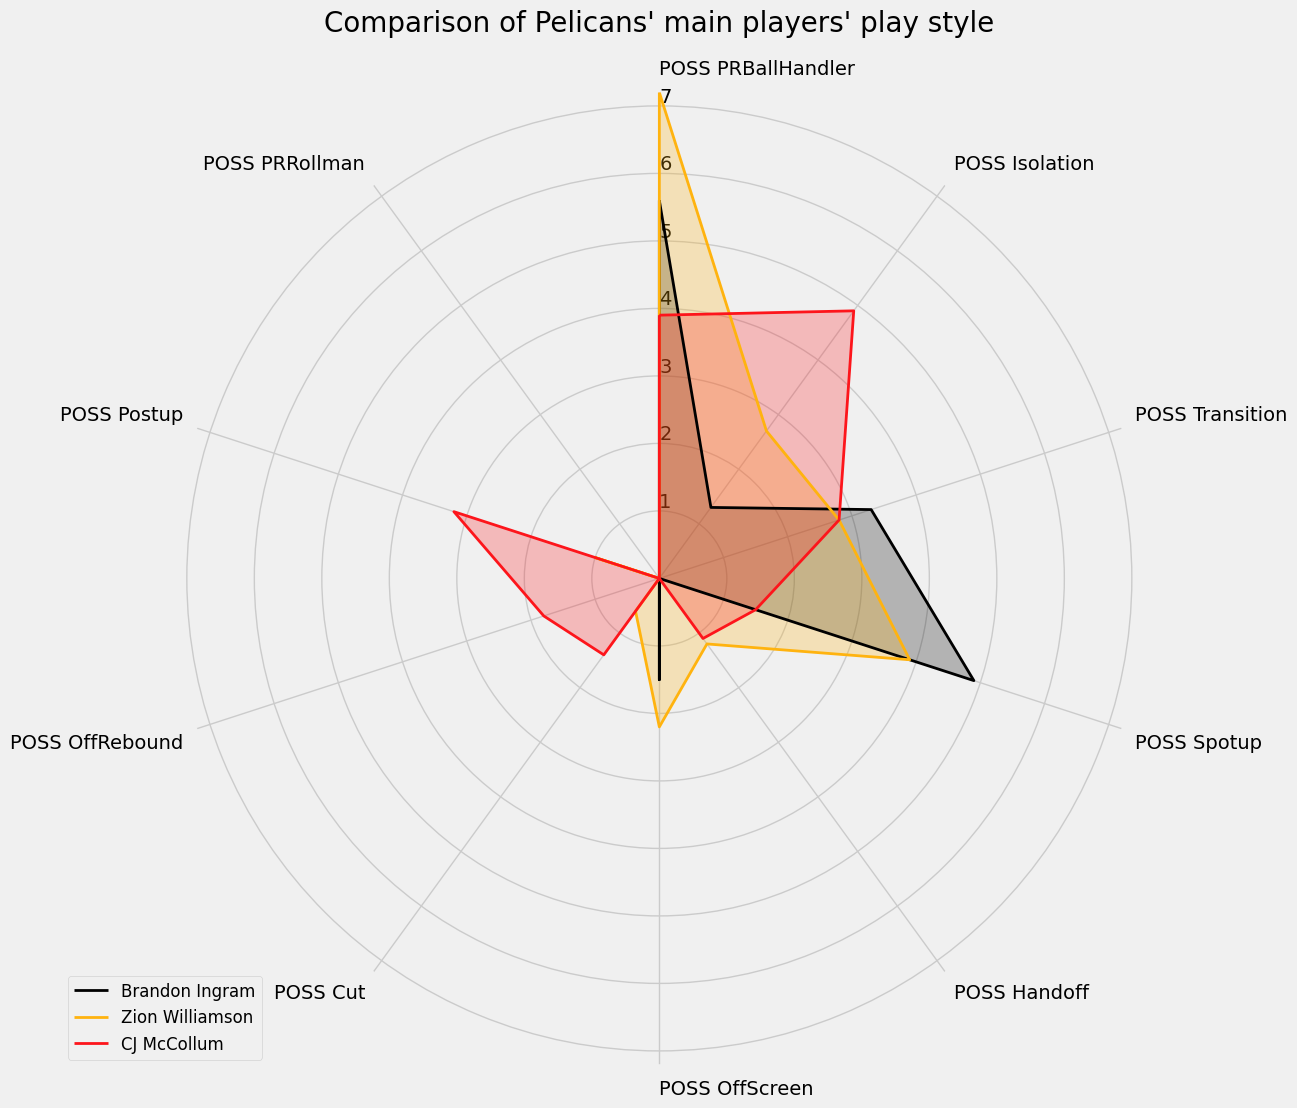

In [74]:
#category = 'PTS'
#cur_df = get_interesting_data(cur_year, category)
player_name = 'Brandon Ingram'
player_name_second = 'Zion Williamson'
player_name_third = 'CJ McCollum'
#team_last = merged_df.loc[merged_df.TEAM_NAME == team_name, [column for column in merged_df.columns.tolist() if 'last' in column]]
first_df = cur_df.loc[cur_df.PLAYER_NAME == player_name]
second_df = cur_df.loc[cur_df.PLAYER_NAME == player_name_second]
third_df = cur_df.loc[cur_df.PLAYER_NAME == player_name_third]

#team_last = team_last.rename(columns={item: item.split("_last")[0].split(f"{target_stat}_")[1] for item in team_last.columns})
#team_cur = team_cur.rename(columns={item: item.split("_cur")[0].split(f"{target_stat}_")[1] for item in team_cur.columns})

plot_radar(
    title=f"Comparison of Pelicans' main players' play style",
    data=[third_df.iloc[0][1:], first_df.iloc[0][1:], second_df.iloc[0][1:]],
    labels=[player_name, player_name_second, player_name_third],
    colors=[
        '#000000',
        '#FFB30F',
        '#FD151B'
    ],
    alphas=[0.25, 0.25, 0.25]
)

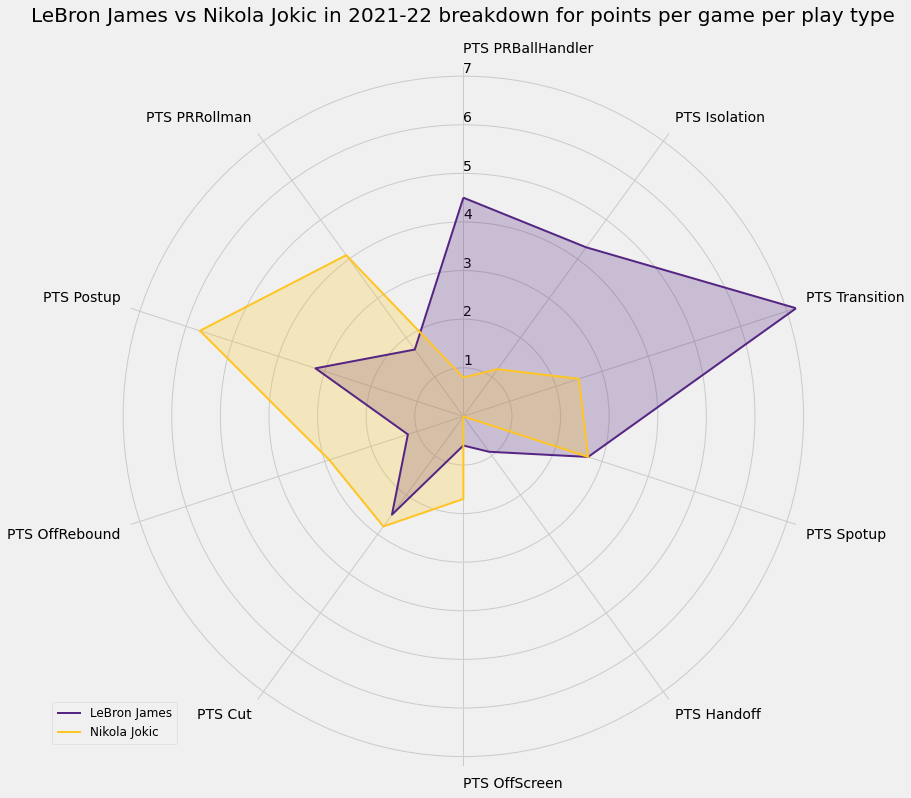

In [22]:
#category = 'PTS'
#cur_df = get_interesting_data(cur_year, category)
player_name = 'LeBron James'
player_name_second = 'Nikola Jokic'
#team_last = merged_df.loc[merged_df.TEAM_NAME == team_name, [column for column in merged_df.columns.tolist() if 'last' in column]]
first_df = cur_df.loc[cur_df.PLAYER_NAME == player_name]
second_df = cur_df.loc[cur_df.PLAYER_NAME == player_name_second]


#team_last = team_last.rename(columns={item: item.split("_last")[0].split(f"{target_stat}_")[1] for item in team_last.columns})
#team_cur = team_cur.rename(columns={item: item.split("_cur")[0].split(f"{target_stat}_")[1] for item in team_cur.columns})

plot_radar(
    title=f"{player_name} vs {player_name_second} in 2021-22 breakdown for points per game per play type",
    data=[first_df.iloc[0][1:], second_df.iloc[0][1:]],
    labels=[player_name, player_name_second],
    colors=[
        '#552583',
        '#FEC524',
    ],
    alphas=[0.25, 0.25]
)

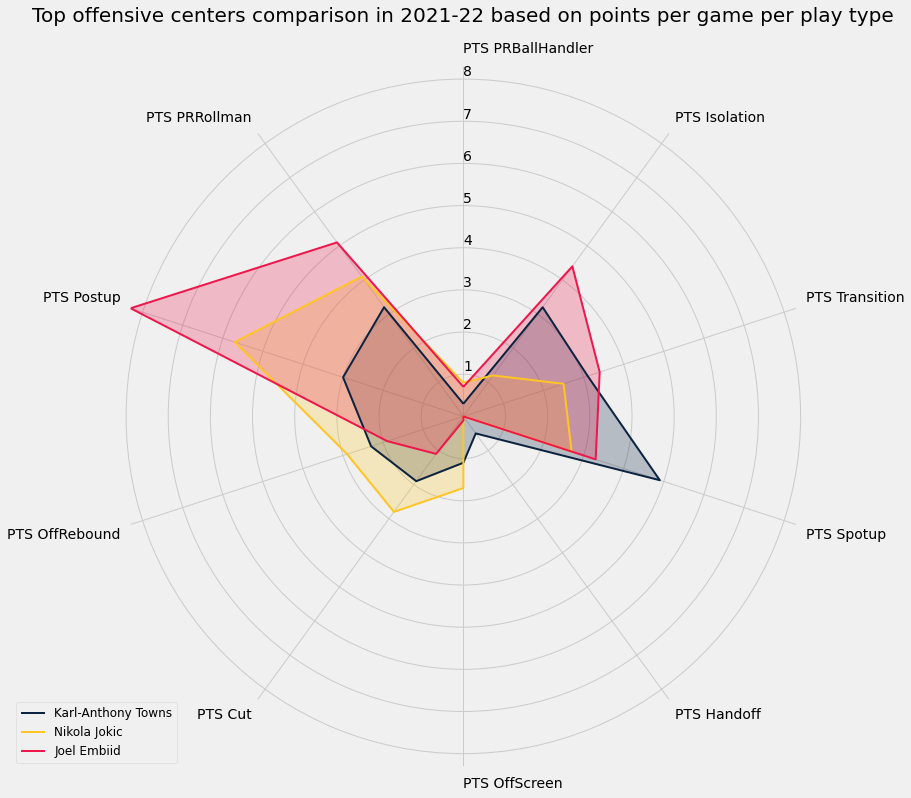

In [31]:
#category = 'PTS'
#cur_df = get_interesting_data(cur_year, category)
player_name = 'Karl-Anthony Towns'
player_name_second = 'Nikola Jokic'
player_name_third = 'Joel Embiid'
#team_last = merged_df.loc[merged_df.TEAM_NAME == team_name, [column for column in merged_df.columns.tolist() if 'last' in column]]
first_df = cur_df.loc[cur_df.PLAYER_NAME == player_name]
second_df = cur_df.loc[cur_df.PLAYER_NAME == player_name_second]
third_df = cur_df.loc[cur_df.PLAYER_NAME == player_name_third]


#team_last = team_last.rename(columns={item: item.split("_last")[0].split(f"{target_stat}_")[1] for item in team_last.columns})
#team_cur = team_cur.rename(columns={item: item.split("_cur")[0].split(f"{target_stat}_")[1] for item in team_cur.columns})

plot_radar(
    title=f"Top offensive centers comparison in 2021-22 based on points per game per play type",
    data=[first_df.iloc[0][1:], second_df.iloc[0][1:], third_df.iloc[0][1:]],
    labels=[player_name, player_name_second, player_name_third],
    colors=[
        '#0C2340',
        '#FEC524',
        '#ED174C'
    ],
    alphas=[0.25, 0.25, 0.25]
)

In [23]:
minutes_names_only = players_regular_stats.loc[:, ['PLAYER_NAME', 'GP', 'MIN']]

In [24]:
merged_df = pd.merge(left=merged_df, right=minutes_names_only, on='PLAYER_NAME')

In [25]:
merged_df = merged_df.loc[(merged_df.GP > 15) & (merged_df.MIN >= 30)]

In [26]:
merged_df.sort_values(by='COSINE_SIMILARITY')

PLAYER_NAME  PTS_PRBallHandler_last  PTS_Isolation_last  \
262         Reggie Jackson                     2.3                 1.1   
125              Josh Hart                     0.2                 0.0   
32            Jimmy Butler                     6.0                 1.7   
313           Desmond Bane                     0.5                 0.0   
177          Tobias Harris                     4.2                 1.6   
..                     ...                     ...                 ...   
139           De'Aaron Fox                    10.4                 2.5   
12   Giannis Antetokounmpo                     2.2                 4.8   
229            LaMelo Ball                     4.5                 1.6   
50        Bojan Bogdanovic                     1.4                 0.5   
47           Royce O'Neale                     0.0                 0.0   

     PTS_Transition_last  PTS_Spotup_last  PTS_Handoff_last  \
262                  1.8              4.0               0.4   
125                  3.0              4.4               0.4   
32                   4.1              2.4               1.1   
313                  2.2              4.2               0.8   
177                  4.1              2.7               0.8   
..                   ...              ...               ...   
139                  5.6              4.2               0.9   
12                   8.2              2.2               0.1   
229                  3.5              3.6               1.0   
50                   3.6              5.7               0.7   
47                   2.0              3.7               0.0   

     PTS_OffScreen_last  PTS_Cut_last  PTS_OffRebound_last  PTS_Postup_last  \
262                 0.0           0.0                  0.1              0.0   
125                 0.0           0.0                  0.5              0.0   
32                  0.3           1.6                  1.1              1.3   
313                 0.4           0.5                  0.0              0.0   
177                 0.4           0.9                  0.8              2.7   
..                  ...           ...                  ...              ...   
139                 0.0           0.0                  0.2              0.3   
12                  0.2           3.0                  1.4              3.1   
229                 0.3           0.2                  0.5              0.0   
50                  1.8           0.7                  0.4              1.4   
47                  0.0           0.2                  0.4              0.0   

     ...  OffRebound_diff  Postup_diff  PRRollman_diff  LAST_NORM   CUR_NORM  \
262  ...             0.01         0.00            0.01   5.091169   8.228609   
125  ...             0.01         0.00            0.00   5.367495   6.808615   
32   ...             0.09         1.69            0.04   8.274660   7.445133   
313  ...             0.16         0.00            0.00   4.876474   7.463913   
177  ...             0.00         0.49            0.01   7.348469   6.715653   
..   ...              ...          ...             ...        ...        ...   
139  ...             0.04         0.00            0.00  12.819906  11.103153   
12   ...             0.16         0.09            0.49  11.127444  11.415779   
229  ...             0.00         0.00            0.00   7.028513   8.705171   
50   ...             0.04         0.01            0.01   7.354590   7.643952   
47   ...             0.04         0.00            0.00   4.248529   4.906119   

     DOT_PRODUCT  EUCLIDEAN_DISTANCE  COSINE_SIMILARITY  GP   MIN  
262    35.400000            4.778075           0.845005  69  31.1  
125    32.409259            3.216943           0.886827  54  33.2  
32     56.830000            3.200000           0.922476  49  33.7  
313    33.600000            3.505710           0.923138  68  30.0  
177    46.000000            2.664583           0.932122  62  35.1  
..           ...                 ...               